# Tutorial: Generating planetary systems

In this tutorial, we will review how to use the Generator class to generate a sample of planetary systems, using the updated small planet occurrence rates of Bergsten et al. (2022).

## Setup

Let's start by importing the necessary module from Bioverse.

In [1]:
# Import numpy
import numpy as np

# Import the Generator class
from bioverse.generator import Generator
from bioverse.constants import ROOT_DIR

# Import pyplot (for making plots later) and adjust some of its settings
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 20.

## Loading the Generator

The first step in using Bioverse is to generate a simulated sample of planetary systems. This is accomplished with a Generator object, of which two come pre-installed. Let's open one of them and examine its contents.

In [2]:
# reset the generator every time while I'm testing code
import bioverse
bioverse.generator.reset_transit_generator()

Created a new Generator


In [3]:
# Open the transit mode generator and display its properties
generator = Generator('transit')
generator

Generator with 12 steps:
 0: Function 'create_stars_Gaia' with 7 keyword arguments.
 1: Function 'create_planets_bergsten' with 5 keyword arguments.
 2: Function 'assign_orbital_elements' with 2 keyword arguments.
 3: Function 'geometric_albedo' with 3 keyword arguments.
 4: Function 'impact_parameter' with 1 keyword arguments.
 5: Function 'assign_mass' with no keyword arguments.
 6: Function 'compute_habitable_zone_boundaries' with no keyword arguments.
 7: Function 'compute_transit_params' with no keyword arguments.
 8: Function 'classify_planets' with no keyword arguments.
 9: Function 'scale_height' with no keyword arguments.
10: Function 'Example1_water' with 4 keyword arguments.
11: Function 'Example2_oxygen' with 3 keyword arguments.

### Optional Step: Replacing the occurrence rates of Bergsten et al. (2022) with those from SAG13.
The above Generator features the updated function 'create_planets_bergsten', but we can replace that with some legacy occurrence rates. To replace a function in the program sequence, call generator.replace_step().

In [4]:
# generator.replace_step(new_function='create_planets_SAG13', idx=1)
# # View the new create_planets function
# generator.steps[1]

### Other Modifications to the Generator

Here we see a short description of the planet generation step as well as its keyword arguments. The aforementioned occurrence rates have are only defined for planets with $1.0 \leq R_p \leq 3.5\,R_\oplus$. Extrapolations to smaller radii are possible, but extrapolations to larger radii are not recommended.

While the occurrence rates are also formally defined for $2 \leq P_\mathrm{orb} \leq 100\,$days, extrapolations to longer periods are feasible.

Additionally, the above occurrence rates incorporate stellar mass dependence, but are only defined for $0.56 \leq M_* \leq 1.63\,M_\odot$. We need to update the stellar generator's mass ranges to match this requirement. $\textbf{Intentionally, attempting to use stellar masses beyond this range will cause fatal errors!}$.

$\textbf{Programmer's Note: The mass range from 'create_stars_Gaia' is quite different from that of Bergsten et al.! We're working on expanding the mass range to smaller stars!}$

In [5]:
# Update the stellar mass ranges to be within the defined range
generator.set_arg('M_st_min', 0.56)
generator.set_arg('M_st_max', 1.63)

# Extend the maximum period to 10 years if interested in larger separations.
generator.set_arg('P_max', 10*365)

Some arguments are shared by multiple functions - for example, the `transit_mode` argument tells a couple of functions that only transiting planets are being simulated. 

Initializing the 'transit' generator causes transit_mode=True, but the new create_planets function is (for now) only defined when transit_mode=False.

In [6]:
# Set transit_mode = False for all functions that use it
generator.set_arg('transit_mode', False)

# We can also check on an argument's value as follows:
val = str(generator.get_arg('transit_mode'))
print("\nThe current value of transit_mode is {:s}".format(val))


The current value of transit_mode is False


## Running the Generator

Now, let's use this Generator object to produce an ensemble of transiting planets within 100 parsecs.

In [7]:
sample = generator.generate(d_max=100)
print("Generated a sample of {:d} planets including {:d} exo-Earth candidates.".format(len(sample), sample['EEC'].sum()))

Generated a sample of 42447 planets including 1150 exo-Earth candidates.


Let's plot the period and radius distribution of this planet sample:

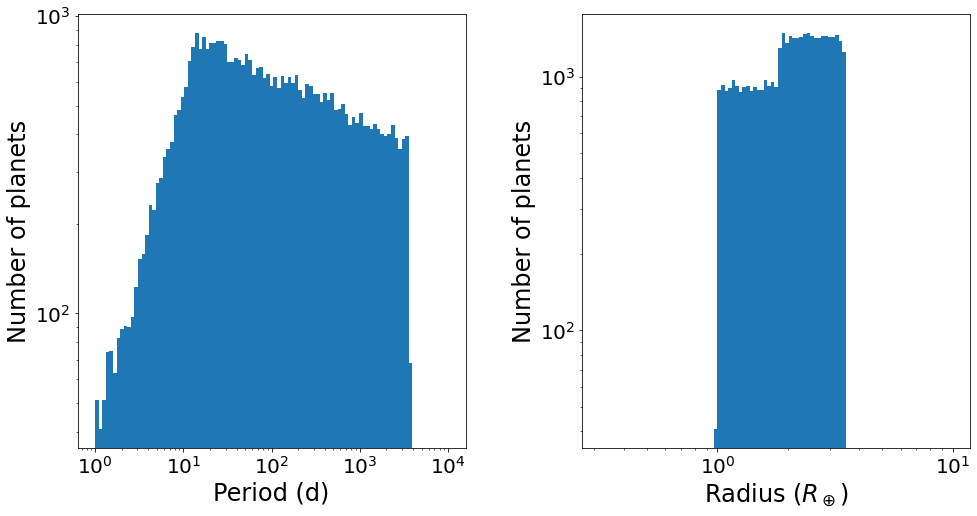

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(16,8))

# Period histogram
P = sample['P']
bins = np.logspace(0, 4, 100)
ax[0].hist(P, bins=bins)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Period (d)', fontsize=24)
ax[0].set_ylabel('Number of planets', fontsize=24)

# Radius histogram
R = sample['R']
bins = np.logspace(-0.5,1,100)
ax[1].hist(R, bins=bins)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Radius ($R_\oplus$)', fontsize=24)
ax[1].set_ylabel('Number of planets', fontsize=24)

plt.subplots_adjust(wspace=0.3)

## Processing Outputs from the Generator

What does the distribution of stellar masses look like?

Text(0.5, 0, 'Stellar Mass [M$_\\odot$]')

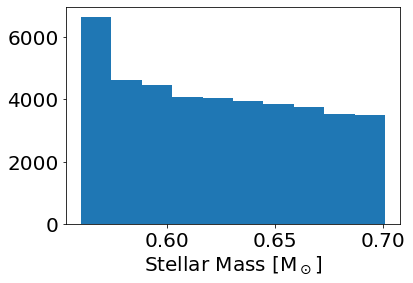

In [9]:
plt.hist(sample['M_st'])
plt.xlabel('Stellar Mass [M$_\odot$]')

What do the fractional occurrence curves look like?

Text(0, 0.5, 'Fractional Occurrence')

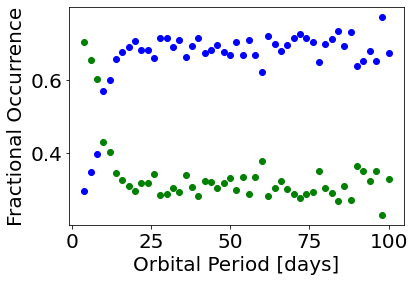

In [10]:
Rsplit = 2*(np.mean(sample['M_st'])/1)**(1/4)
sE = sample[(sample['R'] >= 1.0) & (sample['R'] < Rsplit)]
sN = sample[(sample['R'] >= Rsplit) & (sample['R'] < 3.5)]
pbin = np.linspace(2,100)
for i,p in enumerate(pbin):
    if i>0:
        this_sE = sE[(sE['P'] >= pbin[i-1]) & (sE['P'] < p)]
        this_sN = sN[(sN['P'] >= pbin[i-1]) & (sN['P'] < p)]
        this_small = sample[(sample['P'] >= pbin[i-1]) & (sample['P'] < p)]
        plt.scatter(p,len(this_sE)/len(this_small), c='g')
        plt.scatter(p,len(this_sN)/len(this_small), c='b')
plt.xlabel('Orbital Period [days]')
plt.ylabel('Fractional Occurrence')